## GBIF Exploratory Data Analysis (EDA)

This notebook helps you understand GBIF occurrence data step by step:
- download occurrences from the GBIF API (with caching)
- basic cleaning / normalization
- EDA: missingness, distributions, top species, time trends, geography
- quick quality / sanity checks
- comparison: “recent” vs “~1 year ago” windows (eventDate-based)

**Note**: GBIF data is fetched via an API, so results may change over time.


In [8]:
from pathlib import Path

import numpy as np
import pandas as pd

from pygbif import occurrences

import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for quick point maps
import geopandas as gpd

# City -> coordinates
from geopy.geocoders import Nominatim

# Progress bars for paginated API calls
from tqdm.auto import tqdm

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

sns.set_theme(style="whitegrid")


### 1) Query configuration (City + radius + optional taxon)

We’ll query GBIF occurrences using:
- **CITY** + **RADIUS_KM** → we convert this into a bounding box (min/max lat/lon)
- **TAXON_KEY** (optional) → e.g. `6` means *Plantae*. Set to `None` to fetch **all species**.


In [9]:
# Example: Madrid + surroundings
CITY = "Madrid, Spain"
RADIUS_KM = 30

# Optional filter. Set to None to get all taxa/species.
TAXON_KEY = None  # e.g. 6 for Plantae

# How many records you want to download (GBIF API is paginated)
MAX_RECORDS = 2000
PAGE_SIZE = 300  # GBIF max page size is typically 300

CACHE_DIR = Path("data")
CACHE_DIR.mkdir(exist_ok=True)

# Cache filename is derived from query params
# NOTE: We use JSON Lines (gzipped) for caching to avoid Parquet/Arrow issues in some environments.
safe_city = CITY.lower().replace(",", "").replace(" ", "_")
CACHE_PATH = CACHE_DIR / f"gbif_occurrences_{safe_city}_r{RADIUS_KM}km_taxon{TAXON_KEY}_max{MAX_RECORDS}.jsonl.gz"

CACHE_PATH

PosixPath('data/gbif_occurrences_madrid_spain_r30km_taxonNone_max2000.jsonl.gz')

### 2) What is `pygbif`?

`pygbif` is a Python library that acts as a **thin wrapper around the GBIF API**.

- **GBIF** publishes open biodiversity data: mostly **occurrence records** (who/what, where, when) + lots of metadata.
- `pygbif` lets you query that API from Python without manually writing HTTP requests and parsing JSON.

In this notebook the key call is:
- `occurrences.search(...)`: downloads a page of occurrences (JSON) that we convert into a `pandas.DataFrame`.

Practical caveats:
- It’s an API → can be slow, paginated, and sometimes rate-limited.
- Fields are messy/optional → many missing values, inconsistent date formats, etc.


In [10]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using OpenStreetMap Nominatim."""
    geolocator = Nominatim(user_agent="gbif_eda")
    location = geolocator.geocode(city)
    if location is None:
        raise ValueError(f"Could not geocode city: {city!r}")
    return float(location.latitude), float(location.longitude)


def bbox_from_city(city: str, radius_km: float) -> dict:
    """Approximate bounding box around a city center.

    Uses a simple conversion:
    - 1 degree latitude ~ 111 km
    - 1 degree longitude ~ 111 km * cos(latitude)

    Good enough for an EDA demo.
    """
    lat, lon = geocode_city(city)
    lat_delta = radius_km / 111.0
    lon_delta = radius_km / (111.0 * np.cos(np.deg2rad(lat)))
    return {
        "min_lat": lat - lat_delta,
        "max_lat": lat + lat_delta,
        "min_lon": lon - lon_delta,
        "max_lon": lon + lon_delta,
        "center_lat": lat,
        "center_lon": lon,
    }


def fetch_gbif_occurrences_paged(
    bbox: dict,
    taxon_key: int | None,
    max_records: int = 1000,
    page_size: int = 300,
) -> pd.DataFrame:
    """Fetch GBIF occurrences with pagination.

    - bbox: dict with min/max lat/lon
    - taxon_key: optional. If None, fetch all taxa.
    """
    all_results: list[dict] = []
    offset = 0

    with tqdm(total=max_records, desc="Downloading GBIF occurrences") as pbar:
        while offset < max_records:
            limit = min(page_size, max_records - offset)

            kwargs = dict(
                decimalLatitude=f"{bbox['min_lat']},{bbox['max_lat']}",
                decimalLongitude=f"{bbox['min_lon']},{bbox['max_lon']}",
                hasCoordinate=True,
                limit=limit,
                offset=offset,
            )
            if taxon_key is not None:
                kwargs["taxonKey"] = taxon_key

            resp = occurrences.search(**kwargs)
            results = resp.get("results", [])
            if not results:
                break

            all_results.extend(results)
            offset += len(results)
            pbar.update(len(results))

            # If GBIF returns fewer results than requested, we reached the end.
            if len(results) < limit:
                break

    return pd.DataFrame(all_results)


def _read_cache_jsonl_gz(path: Path) -> pd.DataFrame:
    return pd.read_json(path, orient="records", lines=True, compression="infer")


def _write_cache_jsonl_gz(df: pd.DataFrame, path: Path) -> None:
    df.to_json(path, orient="records", lines=True, compression="infer")


def load_or_fetch(cache_path: Path, bbox: dict) -> pd.DataFrame:
    if cache_path.exists():
        return _read_cache_jsonl_gz(cache_path)

    df_raw = fetch_gbif_occurrences_paged(
        bbox=bbox,
        taxon_key=TAXON_KEY,
        max_records=MAX_RECORDS,
        page_size=PAGE_SIZE,
    )
    _write_cache_jsonl_gz(df_raw, cache_path)
    return df_raw


BBOX = bbox_from_city(CITY, RADIUS_KM)
BBOX


{'min_lat': 40.146511729729724,
 'max_lat': 40.68705227027027,
 'min_lon': np.float64(-4.058495932977153),
 'max_lon': np.float64(-3.3485180670228476),
 'center_lat': 40.416782,
 'center_lon': -3.703507}

### 3) Download + cache occurrences for the selected city

We cache the raw GBIF response to a **compressed JSON Lines** file (`.jsonl.gz`) so you don’t hit the API on every rerun.

If you change `CITY`, `RADIUS_KM`, `TAXON_KEY`, or `MAX_RECORDS`, a different cache file will be used.


In [11]:
df_raw = load_or_fetch(CACHE_PATH, BBOX)

print("City:", CITY)
print("Radius (km):", RADIUS_KM)
print("Taxon key:", TAXON_KEY)
print("Requested max records:", MAX_RECORDS)
print("Downloaded records:", len(df_raw))

df_raw.head(10)

City: Madrid, Spain
Radius (km): 30
Taxon key: None
Requested max records: 2000
Downloaded records: 2000


,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,extensions,basisOfRecord,occurrenceStatus,classifications,taxonKey,kingdomKey,phylumKey,classKey,orderKey,familyKey,genusKey,speciesKey,acceptedTaxonKey,scientificName,scientificNameAuthorship,acceptedScientificName,kingdom,phylum,order,family,genus,species,genericName,specificEpithet,taxonRank,taxonomicStatus,iucnRedListCategory,dateIdentified,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,continent,stateProvince,gadm,year,month,day,eventDate,startDayOfYear,endDayOfYear,issues,modified,lastInterpreted,references,license,isSequenced,identifiers,media,facts,relations,isInCluster,datasetName,recordedBy,identifiedBy,dnaSequenceID,geodeticDatum,class,countryCode,recordedByIDs,identifiedByIDs,gbifRegion,country,publishedByGbifRegion,rightsHolder,identifier,http://unknown.org/nick,verbatimEventDate,gbifID,verbatimLocality,collectionCode,occurrenceID,taxonID,http://unknown.org/captive_cultivated,catalogNumber,institutionCode,eventTime,identificationID,dynamicProperties,vitality,projectId,occurrenceRemarks,lifeStage,informationWithheld,sex,infraspecificEpithet,reproductiveCondition,identificationRemarks,recordNumber,scientificNameID,identificationVerificationStatus,taxonRemarks,vernacularName,http://unknown.org/taxonRankID,taxonConceptID,http://unknown.org/species,individualCount,samplingProtocol,habitat,locality,distanceFromCentroidInMeters,eventID
0,5938028331,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2026-01-08T02:05:14.848+00:00,2026-01-08T22:26:41.313+00:00,575,{'http://rs.gbif.org/terms/1.0/Multimedia': [{...,HUMAN_OBSERVATION,PRESENT,{'7ddf754f-d193-4cc9-b351-99906754a03b': {'usa...,2492956.0,1.0,44.0,212.0,729.0,5285.0,2492941.0,2492956.0,2492956.0,"Sylvia atricapilla (Linnaeus, 1758)","(Linnaeus, 1758)","Sylvia atricapilla (Linnaeus, 1758)",Animalia,Chordata,Passeriformes,Sylviidae,Sylvia,Sylvia atricapilla,Sylvia,atricapilla,SPECIES,ACCEPTED,LC,2026-01-03T15:27:44,40.461052,-3.606193,1.0,EUROPE,Comunidad de Madrid,"{'level0': {'gid': 'ESP', 'name': 'Spain'}, 'l...",2026,1,3,2026-01-03T13:43,3,3,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO...",2026-01-03 15:34:36+00:00,2026-01-08T22:26:41.313+00:00,https://www.inaturalist.org/observations/33330...,http://creativecommons.org/licenses/by-nc/4.0/...,False,[{'identifier': '333301770'}],"[{'type': 'StillImage', 'format': 'image/jpeg'...",[],[],False,iNaturalist research-grade observations,Sergio Ibarra,Sergio Ibarra,[],WGS84,Aves,ES,[],[],EUROPE,Spain,NORTH_AMERICA,Sergio Ibarra,333301770,sergio_ibarra_mellado,2026/01/03 1:43 PM,5938028331,"Corralejos, Barajas, 28042 Madrid, Spain",Observations,https://www.inaturalist.org/observations/33330...,15282.0,wild,333301770.0,iNaturalist,13:43:00+01:00,745977322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5938028504,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2026-01-08T02:05:14.848+00:00,2026-01-08T23:30:21.263+00:00,575,{'http://rs.gbif.org/terms/1.0/Multimedia': [{...,HUMAN_OBSERVATION,PRESENT,{'7ddf754f-d193-4cc9-b351-99906754a03b': {'usa...,2498344.0,1.0,44.0,212.0,1108.0,2986.0,8996942.0,2498344.0,2498344.0,"Cygnus atratus (Latham, 1790)","(Latham, 1790)","Cygnus atratus (Latham, 1790)",Animalia,Chordata,Anseriformes,Anatidae,Cygnus,Cygnus atratus,Cygnus,atratus,SPECIES,ACCEPTED,LC,2026-01-03T15:13:04,40.413533,-3.681392,NaN,EUROPE,Comunidad de Madrid,"{'level0': {'gid': 'ESP', 'name': 'Spain'}, 'l...",2026,1,3,2026-01-03T12:20:59,3,3,"[CONTINENT_DERIVED_FROM_COORDINATES, TAXON_ID_...",2026-01-03 21:45:58+00:00,2026-01-08T23:30:21.263+00:00,https://www.inaturalist.org/observations/33330...,http:/

### 4) Build a clean analysis table

GBIF records contain many fields and many missing values. For EDA we usually keep a **small, consistent subset**.

Below we:
- select common columns if present
- normalize `eventDate`
- ensure coordinates are numeric
- create helper columns like `event_year` and `event_month`


In [8]:
def pick_existing_columns(df: pd.DataFrame, cols: list[str]) -> list[str]:
    return [c for c in cols if c in df.columns]


CANDIDATE_COLS = [
    "key",
    "occurrenceID",
    "datasetKey",
    "publishingOrgKey",
    "institutionCode",
    "collectionCode",
    "basisOfRecord",
    "occurrenceStatus",
    "scientificName",
    "species",
    "genus",
    "family",
    "order",
    "class",
    "phylum",
    "kingdom",
    "taxonKey",
    "speciesKey",
    "decimalLatitude",
    "decimalLongitude",
    "coordinateUncertaintyInMeters",
    "country",
    "countryCode",
    "stateProvince",
    "municipality",
    "locality",
    "eventDate",
    "year",
    "month",
    "day",
    "recordedBy",
    "identifiedBy",
]

cols = pick_existing_columns(df_raw, CANDIDATE_COLS)
df = df_raw[cols].copy()

# Parse eventDate if present
if "eventDate" in df.columns:
    df["eventDate"] = pd.to_datetime(df["eventDate"], errors="coerce", utc=True)

# Force coordinates to numeric
for c in ["decimalLatitude", "decimalLongitude", "coordinateUncertaintyInMeters"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Helper time columns
if "eventDate" in df.columns:
    df["event_year"] = df["eventDate"].dt.year
    df["event_month"] = df["eventDate"].dt.to_period("M").astype(str)

df.shape

/var/folders/7t/yrpkmv3n0vj6ml2djk_2bdk80000gn/T/ipykernel_30194/148246204.py:55: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["event_month"] = df["eventDate"].dt.to_period("M").astype(str)


(2000, 33)

### 5) Quick overview

These cells answer basic questions:
- How many records and columns do we have?
- What are the dtypes?
- How many unique species are present (in this downloaded sample)?


In [9]:
display(df.head(5))

print("Columns:", len(df.columns))
print("Records:", len(df))

if "species" in df.columns:
    print("Unique species:", df["species"].nunique(dropna=True))

df.dtypes

,key,occurrenceID,datasetKey,publishingOrgKey,institutionCode,collectionCode,basisOfRecord,occurrenceStatus,scientificName,species,genus,family,order,class,phylum,kingdom,taxonKey,speciesKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,country,countryCode,stateProvince,locality,eventDate,year,month,day,recordedBy,identifiedBy,event_year,event_month
0,5938028331,https://www.inaturalist.org/observations/33330...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Sylvia atricapilla (Linnaeus, 1758)",Sylvia atricapilla,Sylvia,Sylviidae,Passeriformes,Aves,Chordata,Animalia,2492956.0,2492956.0,40.461052,-3.606193,1.0,Spain,ES,Comunidad de Madrid,NaN,2026-01-03 13:43:00+00:00,2026,1,3,Sergio Ibarra,Sergio Ibarra,2026.0,2026-01
1,5938028504,https://www.inaturalist.org/observations/33330...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Cygnus atratus (Latham, 1790)",Cygnus atratus,Cygnus,Anatidae,Anseriformes,Aves,Chordata,Animalia,2498344.0,2498344.0,40.413533,-3.681392,NaN,Spain,ES,Comunidad de Madrid,NaN,NaT,2026,1,3,mr_ma89,mr_ma89,NaN,NaN
2,5938029310,https://www.inaturalist.org/observations/33302...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Phoenicurus ochruros (S.G.Gmelin, 1774)",Phoenicurus ochruros,Phoenicurus,Muscicapidae,Passeriformes,Aves,Chordata,Animalia,5739315.0,5739315.0,40.563150,-3.636328,2.0,Spain,ES,Comunidad de Madrid,NaN,2026-01-01 13:23:00+00:00,2026,1,1,San Juan,San Juan,2026.0,2026-01
3,5938030206,https://www.inaturalist.org/observations/33329...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Passer domesticus (Linnaeus, 1758)",Passer domesticus,Passer,Passeridae,Passeriformes,Aves,Chordata,Animalia,5231190.0,5231190.0,40.416325,-3.694387,29.0,Spain,ES,Comunidad de Madrid,NaN,NaT,2026,1,3,greg012345,greg012345,NaN,NaN
4,5938031858,https://www.inaturalist.org/observations/33341...,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,PRESENT,"Linaria cannabina (Linnaeus, 1758)",Linaria cannabina,Linaria,Fringillidae,Passeriformes,Aves,Chordata,Animalia,8104397.0,8104397.0,40.411595,-3.489913,425.0,Spain,ES,Comunidad de Madrid,NaN,2026-01-03 13:00:00+00:00,2026,1,3,Manuel Torvisco Najarro,Manuel Torvisco Najarro,2026.0,2026-01


Columns: 33
Records: 2000
Unique species: 341


key                                            int64
occurrenceID                                     str
datasetKey                                       str
publishingOrgKey                                 str
institutionCode                                  str
collectionCode                                   str
basisOfRecord                                    str
occurrenceStatus                                 str
scientificName                                   str
species                                          str
genus                                            str
family                                           str
order                                            str
class                                            str
phylum                                           str
kingdom                                          str
taxonKey                                     float64
speciesKey                                   float64
decimalLatitude                              f

### 6) Missing values (missingness)

GBIF data is heterogeneous: different datasets provide different fields.

We’ll compute **% missing per column** to see what we can reliably analyze.


In [10]:
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct.to_frame("missing_%").head(25)

,missing_%
locality,80.95
event_month,45.50
event_year,45.50
eventDate,45.50
institutionCode,19.30
collectionCode,19.30
identifiedBy,19.20
coordinateUncertaintyInMeters,17.90
species,0.50
class,0.50


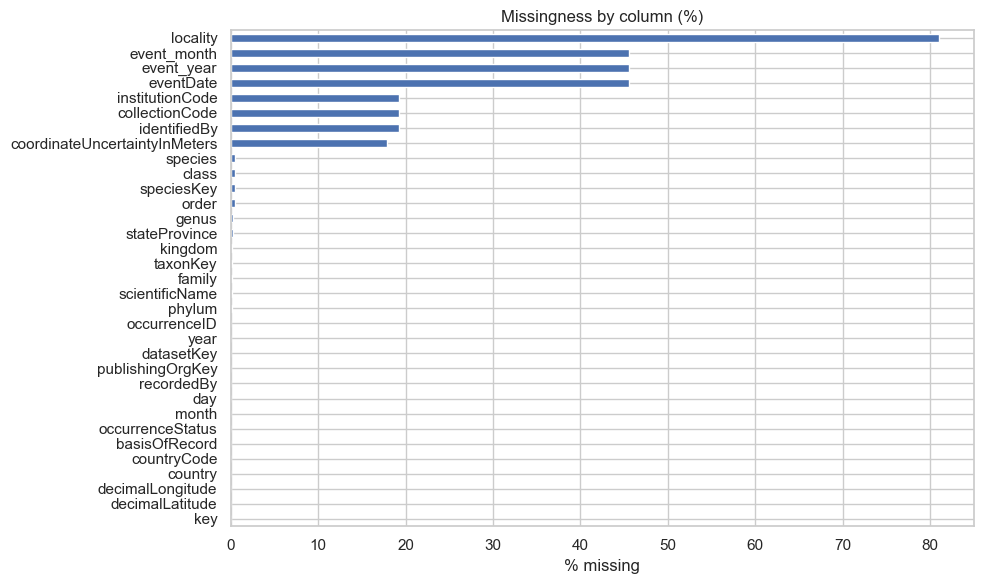

In [11]:
plt.figure(figsize=(10, 6))
missing_pct[::-1].plot(kind="barh")
plt.title("Missingness by column (%)")
plt.xlabel("% missing")
plt.tight_layout()
plt.show()

### 7) Species in the selected area (e.g., Madrid + surroundings)

Two common views:
- **Top species by number of records** (very common in citizen science datasets)
- **Species richness** = number of unique species in the sample

Remember: this is a *downloaded sample* (limited by `MAX_RECORDS`), not necessarily all GBIF records.


Species richness (unique species): 341
Top 10 species by record count:


,records
species,
Pica pica,81
Phylloscopus collybita,76
Milvus milvus,59
Passer domesticus,56
Columba palumbus,46
Ciconia ciconia,45
Larus fuscus,44
Erithacus rubecula,42
Parus major,40


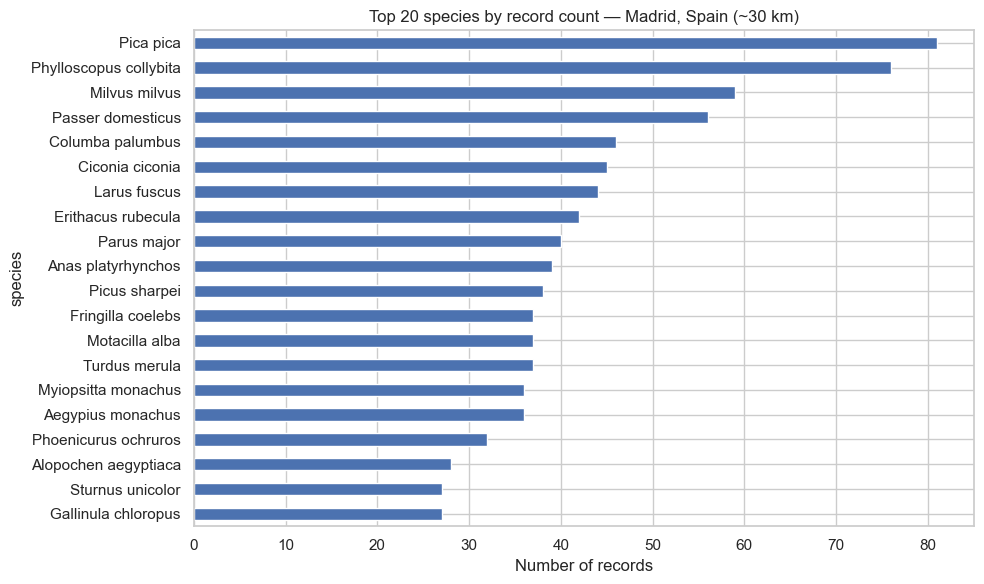

In [12]:
if "species" not in df.columns:
    raise ValueError("No 'species' column found in the downloaded data.")

species_counts = df["species"].value_counts(dropna=True)

print("Species richness (unique species):", df["species"].nunique(dropna=True))
print("Top 10 species by record count:")
display(species_counts.head(10).to_frame("records"))

plt.figure(figsize=(10, 6))
species_counts.head(20).sort_values().plot(kind="barh")
plt.title(f"Top 20 species by record count — {CITY} (~{RADIUS_KM} km)")
plt.xlabel("Number of records")
plt.tight_layout()
plt.show()

### 8) Time trends (when were observations made?)

We’ll look at:
- records over time (monthly)
- species richness over time (monthly)

Notes:
- `eventDate` can be missing or messy
- a spike might reflect sampling effort (more observers), not ecology


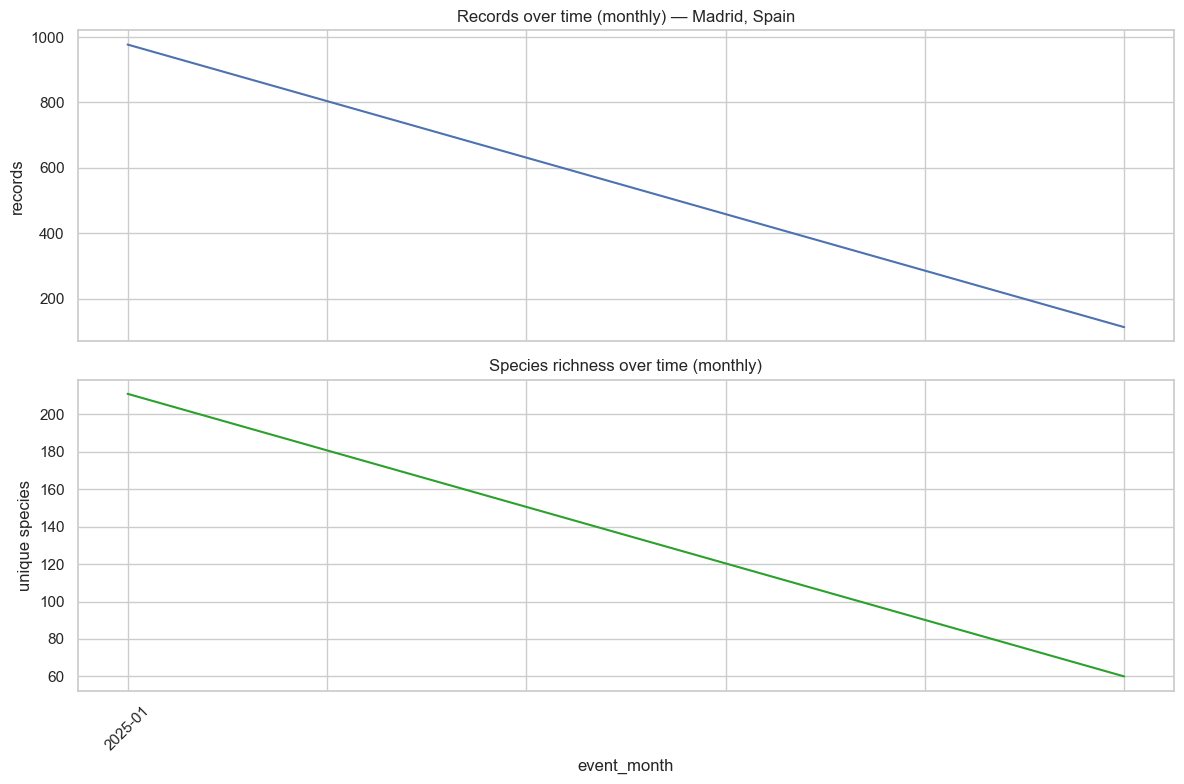

In [13]:
if "eventDate" not in df.columns:
    raise ValueError("No 'eventDate' column found. You can still do non-time EDA.")

# Keep only rows with valid eventDate and species
df_time = df.dropna(subset=["eventDate"]).copy()

records_by_month = df_time.groupby("event_month").size().rename("records")
richness_by_month = df_time.groupby("event_month")["species"].nunique().rename("unique_species")

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
records_by_month.plot(ax=ax[0])
ax[0].set_title(f"Records over time (monthly) — {CITY}")
ax[0].set_ylabel("records")

richness_by_month.plot(ax=ax[1], color="tab:green")
ax[1].set_title("Species richness over time (monthly)")
ax[1].set_ylabel("unique species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 9) Geography (where are the points?)

We’ll do two quick checks:
- a scatter plot of lon/lat
- a simple GeoPandas point plot

This is mainly for sanity-checking (e.g. no points far outside the area).


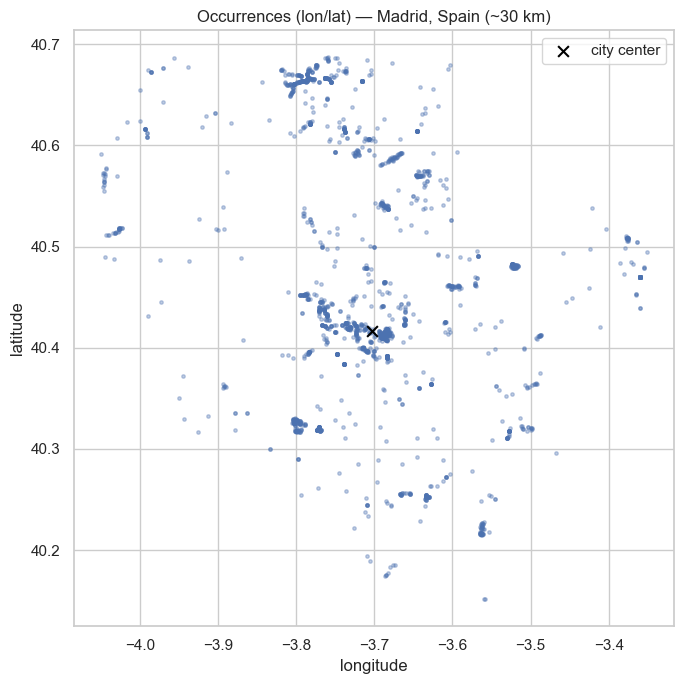

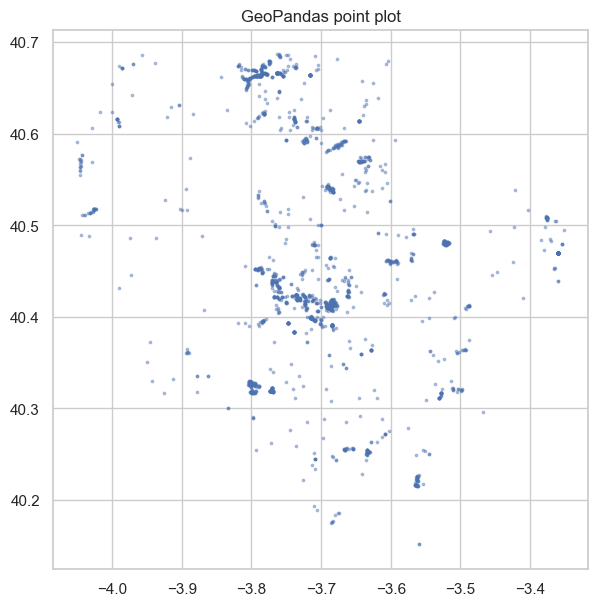

In [14]:
required_geo = {"decimalLatitude", "decimalLongitude"}
if not required_geo.issubset(df.columns):
    raise ValueError("Missing coordinates columns for geography plots.")

df_geo = df.dropna(subset=["decimalLatitude", "decimalLongitude"]).copy()

plt.figure(figsize=(7, 7))
plt.scatter(df_geo["decimalLongitude"], df_geo["decimalLatitude"], s=6, alpha=0.35)
plt.scatter([BBOX["center_lon"]], [BBOX["center_lat"]], s=60, marker="x", color="black", label="city center")
plt.title(f"Occurrences (lon/lat) — {CITY} (~{RADIUS_KM} km)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend()
plt.tight_layout()
plt.show()

# GeoPandas quick plot
try:
    gdf = gpd.GeoDataFrame(
        df_geo,
        geometry=gpd.points_from_xy(df_geo.decimalLongitude, df_geo.decimalLatitude),
        crs="EPSG:4326",
    )
    ax = gdf.plot(markersize=3, figsize=(7, 7), alpha=0.4)
    ax.set_title("GeoPandas point plot")
except Exception as e:
    print("GeoPandas plot failed (often due to local env / backend). Error:", e)

### 10) Data quality / sanity checks

A few practical checks:
- Are coordinates inside the bounding box?
- How many duplicate GBIF `key` values?
- What is the distribution of `basisOfRecord`?
- What does `coordinateUncertaintyInMeters` look like?


Outside bbox: 0 / 2000 (0.00%)
Duplicate GBIF keys: 0


,records
basisOfRecord,
HUMAN_OBSERVATION,2000


count     1642.000000
mean      1952.996955
std       8626.638715
min          1.000000
50%         13.000000
90%        616.000000
99%      27969.000000
max      94428.000000
Name: coordinateUncertaintyInMeters, dtype: float64


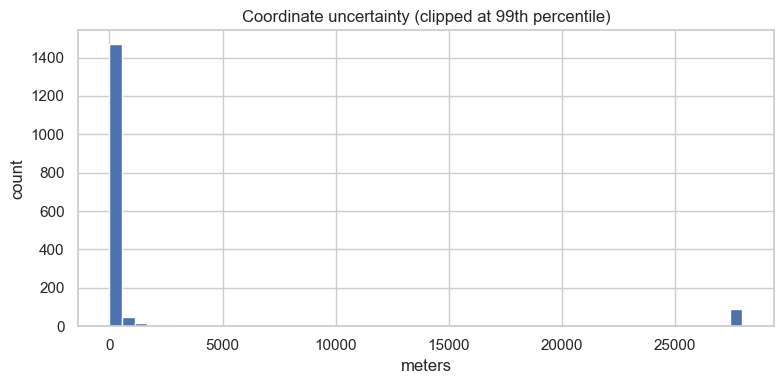

In [15]:
# 1) Points outside bbox (should be rare, but can happen)
if {"decimalLatitude", "decimalLongitude"}.issubset(df.columns):
    df_c = df.dropna(subset=["decimalLatitude", "decimalLongitude"]).copy()
    outside = (
        (df_c["decimalLatitude"] < BBOX["min_lat"]) |
        (df_c["decimalLatitude"] > BBOX["max_lat"]) |
        (df_c["decimalLongitude"] < BBOX["min_lon"]) |
        (df_c["decimalLongitude"] > BBOX["max_lon"])
    )
    print("Outside bbox:", int(outside.sum()), "/", len(df_c), f"({outside.mean()*100:.2f}%)")

# 2) Duplicates by GBIF record key
if "key" in df.columns:
    dup_count = int(df["key"].duplicated().sum())
    print("Duplicate GBIF keys:", dup_count)

# 3) basisOfRecord distribution
if "basisOfRecord" in df.columns:
    display(df["basisOfRecord"].value_counts(dropna=False).to_frame("records"))

# 4) coordinateUncertaintyInMeters
if "coordinateUncertaintyInMeters" in df.columns:
    u = df["coordinateUncertaintyInMeters"].dropna()
    if len(u) > 0:
        print(u.describe(percentiles=[0.5, 0.9, 0.99]))
        plt.figure(figsize=(8, 4))
        plt.hist(u.clip(upper=u.quantile(0.99)), bins=50)
        plt.title("Coordinate uncertainty (clipped at 99th percentile)")
        plt.xlabel("meters")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

### 10b) Licenses & provenance (can we use these data?)

GBIF occurrence records usually carry licensing information at the **record level**.

In practice, you want to check:
- **`license`**: the usage license (often a Creative Commons URL)
- **`rightsHolder`**: who owns the rights
- **`datasetKey`** / **`publishingOrgKey`**: which dataset/provider the record comes from
- **`references`**: a link back to the original source record (good for auditability)

Below we quickly summarize these fields and (optionally) pull a tiny bit of **dataset metadata** for the most common datasets in this download.

In [16]:
# Quick peek at provenance + licensing fields in the *raw* GBIF response
PROV_COLS = [
    "datasetKey",
    "publishingOrgKey",
    "installationKey",
    "basisOfRecord",
    "institutionCode",
    "collectionCode",
    "occurrenceID",
    "gbifID",
    "key",
    "eventDate",
    "scientificName",
    "species",
    "decimalLatitude",
    "decimalLongitude",
    "license",
    "rightsHolder",
    "references",
    "issues",
]

prov_cols = [c for c in PROV_COLS if c in df_raw.columns]
print("Raw columns:", len(df_raw.columns))
print("Provenance columns present:", prov_cols)

display(df_raw[prov_cols].head(10))

Raw columns: 111
Provenance columns present: ['datasetKey', 'publishingOrgKey', 'installationKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'occurrenceID', 'gbifID', 'key', 'eventDate', 'scientificName', 'species', 'decimalLatitude', 'decimalLongitude', 'license', 'rightsHolder', 'references', 'issues']


,datasetKey,publishingOrgKey,installationKey,basisOfRecord,institutionCode,collectionCode,occurrenceID,gbifID,key,eventDate,scientificName,species,decimalLatitude,decimalLongitude,license,rightsHolder,references,issues
0,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33330...,5938028331,5938028331,2026-01-03T13:43,"Sylvia atricapilla (Linnaeus, 1758)",Sylvia atricapilla,40.461052,-3.606193,http://creativecommons.org/licenses/by-nc/4.0/...,Sergio Ibarra,https://www.inaturalist.org/observations/33330...,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO..."
1,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33330...,5938028504,5938028504,2026-01-03T12:20:59,"Cygnus atratus (Latham, 1790)",Cygnus atratus,40.413533,-3.681392,http://creativecommons.org/licenses/by-nc/4.0/...,mr_ma89,https://www.inaturalist.org/observations/33330...,"[CONTINENT_DERIVED_FROM_COORDINATES, TAXON_ID_..."
2,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33302...,5938029310,5938029310,2026-01-01T13:23,"Phoenicurus ochruros (S.G.Gmelin, 1774)",Phoenicurus ochruros,40.563150,-3.636328,http://creativecommons.org/licenses/by-nc/4.0/...,San Juan,https://www.inaturalist.org/observations/33302...,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO..."
3,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33329...,5938030206,5938030206,2026-01-03T15:26:27,"Passer domesticus (Linnaeus, 1758)",Passer domesticus,40.416325,-3.694387,http://creativecommons.org/licenses/by-nc/4.0/...,greg012345,https://www.inaturalist.org/observations/33329...,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO..."
4,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33341...,5938031858,5938031858,2026-01-03T13:00,"Linaria cannabina (Linnaeus, 1758)",Linaria cannabina,40.411595,-3.489913,http://creativecommons.org/licenses/by-nc/4.0/...,Manuel Torvisco Najarro,https://www.inaturalist.org/observations/33341...,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO..."
5,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33316...,5938032334,5938032334,2026-01-02T11:43,"Fringilla coelebs Linnaeus, 1758",Fringilla coelebs,40.326224,-3.803081,http://creativecommons.org/licenses/by-nc/4.0/...,b3ugaz,https://www.inaturalist.org/observations/33316...,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO..."
6,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33328...,5938043956,5938043956,2026-01-03T12:07:45,"Myiopsitta monachus (Boddaert, 1783)",Myiopsitta monachus,40.415638,-3.687492,http://creativecommons.org/licenses/by-nc/4.0/...,Sergio Chozas,https://www.inaturalist.org/observations/33328...,"[COORDINATE_ROUNDED, CONTINENT_DERIVED_FROM_CO..."
7,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,HUMAN_OBSERVATION,iNaturalist,Observations,https://www.inaturalist.org/observations/33357...,5938058312,5938058312,2026-01-05T12:12,"Curruca melanocephala (J.F.Gmelin, 1789)",Curruca melanocephala,40.479890,-3.354649,http://creativecommons.org/licenses/by-nc/4.0/.

,records
license,
http://creativecommons.org/licenses/by-nc/4.0/legalcode,1792
http://creativecommons.org/licenses/by/4.0/legalcode,191
http://creativecommons.org/publicdomain/zero/1.0/legalcode,17


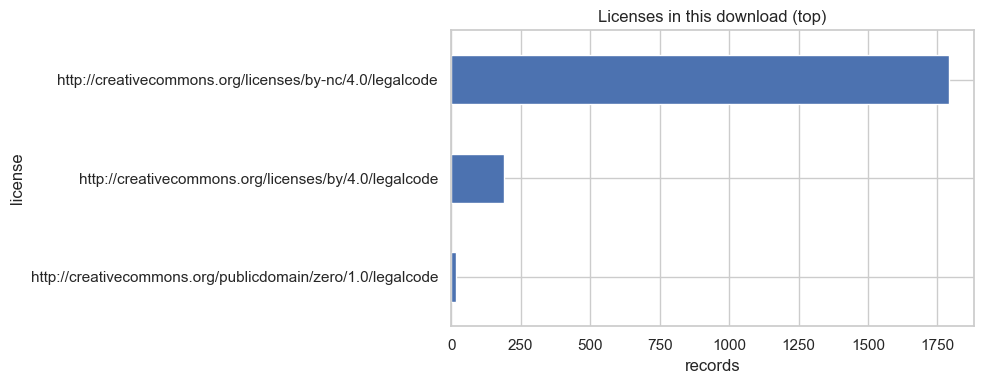

,records
rightsHolder,
Stichting Observation International,381
ARSENIO GONZALEZ NAVARRO,216
Luis de Ossorno,166
Leonardo Quintana,111
Francisco Gómez Prieto,89
Sergio Ibarra,73
Pedro Antonio Lázaro Molinero,71
Javier Castrillo,69
b3ugaz,67


,datasetKey,license,records
0,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/licenses/by-nc/4.0/...,1406
3,8a863029-f435-446a-821e-275f4f641165,http://creativecommons.org/licenses/by-nc/4.0/...,381
1,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/licenses/by/4.0/leg...,191
2,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/publicdomain/zero/1...,17
4,e3ce628e-9683-4af7-b7a9-47eef785d3bb,http://creativecommons.org/licenses/by-nc/4.0/...,5


,datasetKey,error
0,50c9509d-22c7-4a22-a47d-8c48425ef4a7,module 'pygbif.registry' has no attribute 'dat...
1,8a863029-f435-446a-821e-275f4f641165,module 'pygbif.registry' has no attribute 'dat...
2,e3ce628e-9683-4af7-b7a9-47eef785d3bb,module 'pygbif.registry' has no attribute 'dat...


In [17]:
# License distribution + who publishes what
if "license" in df_raw.columns:
    lic = df_raw["license"].fillna("MISSING")
    lic_counts = lic.value_counts()
    display(lic_counts.to_frame("records"))

    plt.figure(figsize=(10, 4))
    lic_counts.head(15).sort_values().plot(kind="barh")
    plt.title("Licenses in this download (top)")
    plt.xlabel("records")
    plt.tight_layout()
    plt.show()
else:
    print("No 'license' field found in df_raw (unexpected for GBIF occurrences).")

if "rightsHolder" in df_raw.columns:
    display(df_raw["rightsHolder"].fillna("MISSING").value_counts().head(15).to_frame("records"))

# Which datasets dominate this sample, and what licenses do they use?
if {"datasetKey", "license"}.issubset(df_raw.columns):
    dl = (
        df_raw.groupby(["datasetKey", "license"]).size()
        .rename("records")
        .reset_index()
        .sort_values("records", ascending=False)
    )
    display(dl.head(30))

# Optional: fetch dataset metadata (name, publisher, license) for the top datasets
try:
    from pygbif import registry

    if "datasetKey" in df_raw.columns:
        top_dataset_keys = df_raw["datasetKey"].dropna().value_counts().head(5).index.tolist()
        meta_rows = []
        for dk in top_dataset_keys:
            try:
                d = registry.dataset(key=dk)
                meta_rows.append(
                    {
                        "datasetKey": dk,
                        "title": d.get("title"),
                        "publisher": (d.get("publisher") or {}).get("title"),
                        "license": d.get("license"),
                        "doi": d.get("doi"),
                    }
                )
            except Exception as e:
                meta_rows.append({"datasetKey": dk, "error": str(e)})

        if meta_rows:
            display(pd.DataFrame(meta_rows))
except Exception as e:
    print("Dataset metadata fetch skipped (pygbif.registry unavailable / network issues):", e)

#### License interpretation (practical)

In this output you have 3 license types (the URLs end with `.../legalcode`, i.e. the full legal text):

- **CC BY-NC 4.0** (`.../by-nc/4.0/...`) — you may copy/share and create derivatives **for non-commercial use only**. You must provide **attribution** (rights/author/source, link to the license) and indicate changes.
- **CC BY 4.0** (`.../by/4.0/...`) — same as above, but **commercial use is allowed** (attribution still required).
- **CC0 1.0** (`.../publicdomain/zero/1.0/...`) — “public domain dedication”: you can generally use it without restrictions (attribution is not required, but keeping source info is still good practice).

What this means for your project:
- If your work may be used in a **commercial context** (product, paid service, marketing demo), then **CC BY‑NC records are not suitable**.
- If this is a **non-commercial** academic/reporting project, **CC BY‑NC is typically OK**, as long as you comply with attribution and don’t imply endorsement.
- The dataset is **mixed**: every record can have its own license — keep `license`/`rightsHolder` with the records and filter based on your use case.

This is not legal advice — licenses have nuances; if you plan to publish commercially, consider a legal review.

In [18]:
# Normalize license URLs into short labels + percentages + quick filtering

def license_label(url: str | None) -> str:
    if url is None or (isinstance(url, float) and pd.isna(url)):
        return "MISSING"
    u = str(url).lower()
    if "/licenses/by-nc/" in u:
        return "CC BY-NC 4.0"
    if "/licenses/by/" in u:
        return "CC BY 4.0"
    if "/publicdomain/zero/" in u:
        return "CC0 1.0"
    return "OTHER"

if "license" in df_raw.columns:
    df_raw["license_label"] = df_raw["license"].map(license_label)
    lic2 = df_raw["license_label"].value_counts(dropna=False)
    lic2_pct = (lic2 / len(df_raw) * 100).round(2)
    display(pd.DataFrame({"records": lic2, "pct": lic2_pct}))

    # If you want to avoid NC risk: keep only CC BY or CC0
    df_open = df_raw[df_raw["license_label"].isin(["CC BY 4.0", "CC0 1.0"])].copy()
    print("Open-ish subset (CC BY / CC0):", len(df_open), "/", len(df_raw))
    display(
        df_open[
            [
                c
                for c in ["species", "eventDate", "datasetKey", "license", "rightsHolder", "references"]
                if c in df_open.columns
            ]
        ].head(5)
    )
else:
    print("No 'license' column in df_raw")

,records,pct
license_label,,
CC BY-NC 4.0,1792,89.60
CC BY 4.0,191,9.55
CC0 1.0,17,0.85


Open-ish subset (CC BY / CC0): 208 / 2000


,species,eventDate,datasetKey,license,rightsHolder,references
17,Aegypius monachus,2026-01-01,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/licenses/by/4.0/leg...,Cristina Villaverde,https://www.inaturalist.org/observations/33363...
31,Populus nigra,2026-01-04T22:44:06,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/publicdomain/zero/1...,Pedro Fernández Martínez,https://www.inaturalist.org/observations/33349...
33,Fringilla coelebs,2026-01-01,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/licenses/by/4.0/leg...,Cristina Villaverde,https://www.inaturalist.org/observations/33363...
34,Ailanthus altissima,2026-01-02T11:51:07,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/publicdomain/zero/1...,Pedro Fernández Martínez,https://www.inaturalist.org/observations/33313...
49,Psittacula krameri,2026-01-04T19:57:34,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://creativecommons.org/publicdomain/zero/1...,Pedro Fernández Martínez,https://www.inaturalist.org/observations/33355...


In [19]:
# GBIF quality flags (issues) and source domains (references)

# Issues are very useful to sanity-check data quality (geospatial problems, date parsing, taxonomic issues, ...)
if "issues" in df_raw.columns:
    issues = df_raw["issues"].dropna()
    if len(issues) == 0:
        print("No issues present in df_raw.")
    else:
        issues_exploded = issues.explode()
        display(issues_exploded.value_counts().head(30).to_frame("records"))

# Where do these records come from (roughly)? Often you’ll see iNaturalist etc.
if "references" in df_raw.columns:
    from urllib.parse import urlparse

    ref = df_raw["references"].dropna().astype(str)
    domains = ref.map(lambda u: urlparse(u).netloc.lower())
    display(domains.value_counts().head(20).to_frame("records"))

,records
issues,
CONTINENT_DERIVED_FROM_COORDINATES,1619
TAXON_ID_NOT_FOUND,1614
COORDINATE_ROUNDED,1517
TAXON_MATCH_HIGHERRANK,6
TAXON_MATCH_NONE,4
SCIENTIFIC_NAME_ID_NOT_FOUND,1
TAXON_CONCEPT_ID_NOT_FOUND,1
TAXON_MATCH_FUZZY,1


,records
references,
www.inaturalist.org,1614


### 11) Compare “recent” vs “~1 year ago”

You asked for “now vs a year ago”. With GBIF, we can approximate that by downloading two **eventDate windows**:
- **Recent**: last 365 days
- **Previous**: 365–730 days ago

Then we compare:
- total records
- species richness
- gained/lost species sets (within the downloaded samples)
- the biggest changes in counts for common species

Important: this is still a sample (limited by `MAX_RECORDS`), so treat it as exploratory.


In [20]:
def date_range_str(start: pd.Timestamp, end: pd.Timestamp) -> str:
    """GBIF API expects date ranges like 'YYYY-MM-DD,YYYY-MM-DD'."""
    return f"{start.date()},{end.date()}"


def fetch_gbif_occurrences_paged_with_eventdate(
    bbox: dict,
    taxon_key: int | None,
    event_date_range: str | None,
    max_records: int = 1000,
    page_size: int = 300,
) -> pd.DataFrame:
    """Same as fetch_gbif_occurrences_paged, but optionally filters by eventDate range."""
    all_results: list[dict] = []
    offset = 0

    with tqdm(total=max_records, desc=f"Downloading GBIF (eventDate={event_date_range})") as pbar:
        while offset < max_records:
            limit = min(page_size, max_records - offset)

            kwargs = dict(
                decimalLatitude=f"{bbox['min_lat']},{bbox['max_lat']}",
                decimalLongitude=f"{bbox['min_lon']},{bbox['max_lon']}",
                hasCoordinate=True,
                limit=limit,
                offset=offset,
            )
            if taxon_key is not None:
                kwargs["taxonKey"] = taxon_key
            if event_date_range is not None:
                kwargs["eventDate"] = event_date_range

            resp = occurrences.search(**kwargs)
            results = resp.get("results", [])
            if not results:
                break

            all_results.extend(results)
            offset += len(results)
            pbar.update(len(results))

            if len(results) < limit:
                break

    return pd.DataFrame(all_results)


def load_or_fetch_with_eventdate(cache_path: Path, bbox: dict, event_date_range: str | None) -> pd.DataFrame:
    if cache_path.exists():
        return _read_cache_jsonl_gz(cache_path)

    df_raw = fetch_gbif_occurrences_paged_with_eventdate(
        bbox=bbox,
        taxon_key=TAXON_KEY,
        event_date_range=event_date_range,
        max_records=MAX_RECORDS,
        page_size=PAGE_SIZE,
    )
    _write_cache_jsonl_gz(df_raw, cache_path)
    return df_raw


today = pd.Timestamp.utcnow().normalize()
recent_start = today - pd.Timedelta(days=365)
prev_start = today - pd.Timedelta(days=730)
prev_end = today - pd.Timedelta(days=365)

recent_range = date_range_str(recent_start, today)
prev_range = date_range_str(prev_start, prev_end)

CACHE_PATH_RECENT = CACHE_DIR / f"gbif_occurrences_{safe_city}_r{RADIUS_KM}km_taxon{TAXON_KEY}_recent365d.jsonl.gz"
CACHE_PATH_PREV = CACHE_DIR / f"gbif_occurrences_{safe_city}_r{RADIUS_KM}km_taxon{TAXON_KEY}_prev365d.jsonl.gz"

print("Recent range:", recent_range)
print("Prev range:", prev_range)
print("Recent cache:", CACHE_PATH_RECENT)
print("Prev cache:", CACHE_PATH_PREV)

raw_recent = load_or_fetch_with_eventdate(CACHE_PATH_RECENT, BBOX, recent_range)
raw_prev = load_or_fetch_with_eventdate(CACHE_PATH_PREV, BBOX, prev_range)

print("Recent downloaded:", len(raw_recent))
print("Prev downloaded:", len(raw_prev))


/var/folders/7t/yrpkmv3n0vj6ml2djk_2bdk80000gn/T/ipykernel_30194/611477444.py:63: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  today = pd.Timestamp.utcnow().normalize()


Recent range: 2025-02-06,2026-02-06
Prev range: 2024-02-07,2025-02-06
Recent cache: data/gbif_occurrences_madrid_spain_r30km_taxonNone_recent365d.jsonl.gz
Prev cache: data/gbif_occurrences_madrid_spain_r30km_taxonNone_prev365d.jsonl.gz
Recent downloaded: 2000
Prev downloaded: 2000


Recent unique species: 358
Prev unique species: 341
Overlap: 191
Gained (in recent only): 167
Lost (in prev only): 150


/var/folders/7t/yrpkmv3n0vj6ml2djk_2bdk80000gn/T/ipykernel_30194/779258801.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  out["event_month"] = out["eventDate"].dt.to_period("M").astype(str)
/var/folders/7t/yrpkmv3n0vj6ml2djk_2bdk80000gn/T/ipykernel_30194/779258801.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  out["event_month"] = out["eventDate"].dt.to_period("M").astype(str)


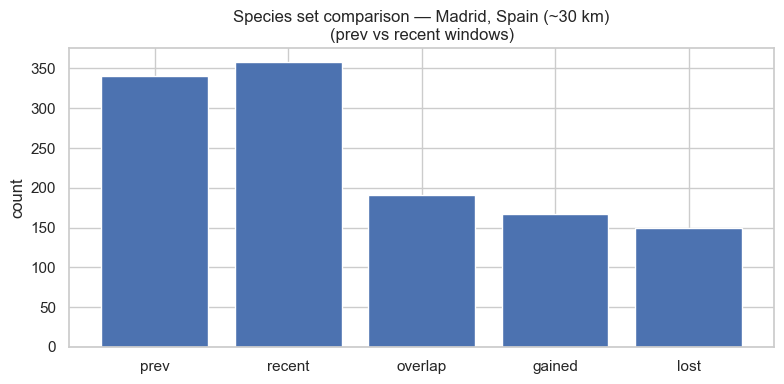

,prev,recent,delta
species,,,
Serinus serinus,19.0,50.0,31.0
Certhia brachydactyla,12.0,34.0,22.0
Grus grus,0.0,21.0,21.0
Monosteira unicostata,0.0,17.0,17.0
Anas platyrhynchos,36.0,53.0,17.0
Columba oenas,4.0,16.0,12.0
Horvathiolus superbus,2.0,13.0,11.0
Turdus merula,41.0,52.0,11.0
Veronica persica,3.0,13.0,10.0


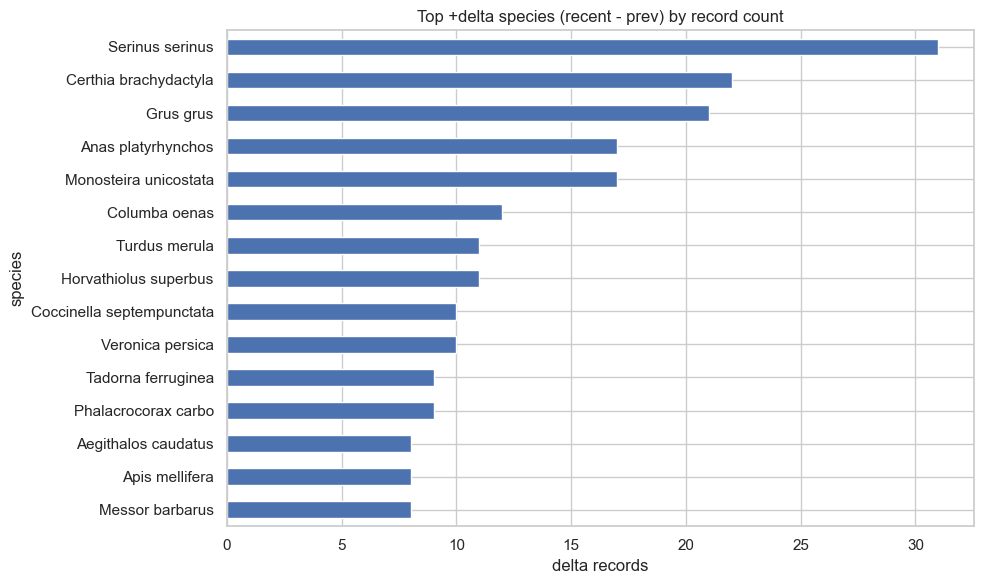

In [21]:
def build_clean_table(df_raw_any: pd.DataFrame) -> pd.DataFrame:
    cols = pick_existing_columns(df_raw_any, CANDIDATE_COLS)
    out = df_raw_any[cols].copy()

    if "eventDate" in out.columns:
        out["eventDate"] = pd.to_datetime(out["eventDate"], errors="coerce", utc=True)
        out["event_year"] = out["eventDate"].dt.year
        out["event_month"] = out["eventDate"].dt.to_period("M").astype(str)

    for c in ["decimalLatitude", "decimalLongitude", "coordinateUncertaintyInMeters"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    return out


df_recent = build_clean_table(raw_recent)
df_prev = build_clean_table(raw_prev)

# Compare richness and overlaps
s_recent = set(df_recent.get("species", pd.Series(dtype=object)).dropna().unique())
s_prev = set(df_prev.get("species", pd.Series(dtype=object)).dropna().unique())

print("Recent unique species:", len(s_recent))
print("Prev unique species:", len(s_prev))
print("Overlap:", len(s_recent & s_prev))
print("Gained (in recent only):", len(s_recent - s_prev))
print("Lost (in prev only):", len(s_prev - s_recent))

# Plot a simple bar comparison
labels = ["prev", "recent", "overlap", "gained", "lost"]
values = [len(s_prev), len(s_recent), len(s_recent & s_prev), len(s_recent - s_prev), len(s_prev - s_recent)]

plt.figure(figsize=(8, 4))
plt.bar(labels, values)
plt.title(f"Species set comparison — {CITY} (~{RADIUS_KM} km)\n(prev vs recent windows)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Biggest changes in record counts for common species
if "species" in df_recent.columns and "species" in df_prev.columns:
    c_recent = df_recent["species"].value_counts(dropna=True).rename("recent")
    c_prev = df_prev["species"].value_counts(dropna=True).rename("prev")
    delta = pd.concat([c_prev, c_recent], axis=1).fillna(0)
    delta["delta"] = delta["recent"] - delta["prev"]

    display(delta.sort_values("delta", ascending=False).head(15))

    plt.figure(figsize=(10, 6))
    delta.sort_values("delta", ascending=False).head(15)["delta"].sort_values().plot(kind="barh")
    plt.title("Top +delta species (recent - prev) by record count")
    plt.xlabel("delta records")
    plt.tight_layout()
    plt.show()

### 12) Month-by-month change for a single species (fast GBIF API counts)

If you want to see how a **single species** changes over time, the most practical approach is to build a **monthly time series**.

Important nuance:
- Using **`eventDate` windows** answers: *“How many occurrences were observed in this month?”* (observation time).
- This is **not** a direct measure of ecological abundance. Counts are heavily affected by **sampling effort** (more observers, platform growth, reporting behavior).

To keep this fast and avoid downloading huge tables, we can query the GBIF Occurrence Search API with `limit=0` and use its **`count`** field.

In [22]:
# Choose a species for the monthly time series
# Tip: start from the most common species in your current sample.

if "species" in df.columns:
    top_species = df["species"].value_counts(dropna=True).head(10)
    display(top_species.to_frame("records"))
    SPECIES_NAME = top_species.index[0]
else:
    SPECIES_NAME = None

print("Selected SPECIES_NAME:", SPECIES_NAME)

# Prefer a stable key if available
SPECIES_KEY = None
if SPECIES_NAME is not None and "speciesKey" in df_raw.columns:
    s = df_raw.loc[df_raw.get("species") == SPECIES_NAME, "speciesKey"].dropna()
    if len(s) > 0:
        SPECIES_KEY = int(s.mode().iloc[0])

print("Selected SPECIES_KEY:", SPECIES_KEY)

# Time window for the monthly series
START = pd.Timestamp("2024-01-01", tz="UTC")
END = pd.Timestamp.now("UTC").normalize()

print("Monthly range:", START.date(), "->", END.date())

,records
species,
Pica pica,81
Phylloscopus collybita,76
Milvus milvus,59
Passer domesticus,56
Columba palumbus,46
Ciconia ciconia,45
Larus fuscus,44
Erithacus rubecula,42
Parus major,40


Selected SPECIES_NAME: Pica pica
Selected SPECIES_KEY: 5229490
Monthly range: 2024-01-01 -> 2026-02-06


GBIF monthly counts (eventDate):   0%|          | 0/26 [00:00<?, ?it/s]

Saved: data/gbif_monthly_counts_madrid_spain_r30km_taxonNone_species5229490_eventDate_2024-01-01_2026-02-06.csv


,month,month_start,count
14,2025-03,2025-03-01 00:00:00+00:00,100
15,2025-04,2025-04-01 00:00:00+00:00,184
16,2025-05,2025-05-01 00:00:00+00:00,77
17,2025-06,2025-06-01 00:00:00+00:00,68
18,2025-07,2025-07-01 00:00:00+00:00,60
19,2025-08,2025-08-01 00:00:00+00:00,64
20,2025-09,2025-09-01 00:00:00+00:00,92
21,2025-10,2025-10-01 00:00:00+00:00,61
22,2025-11,2025-11-01 00:00:00+00:00,106
23,2025-12,2025-12-01 00:00:00+00:00,45


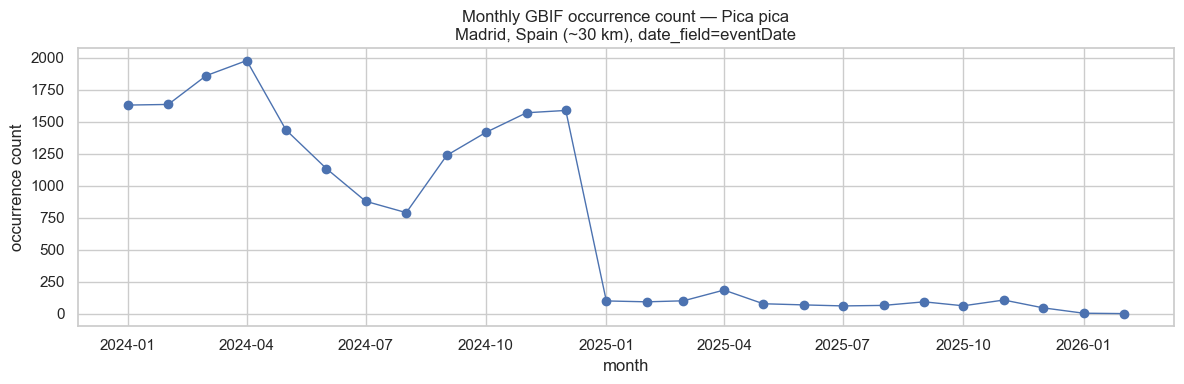

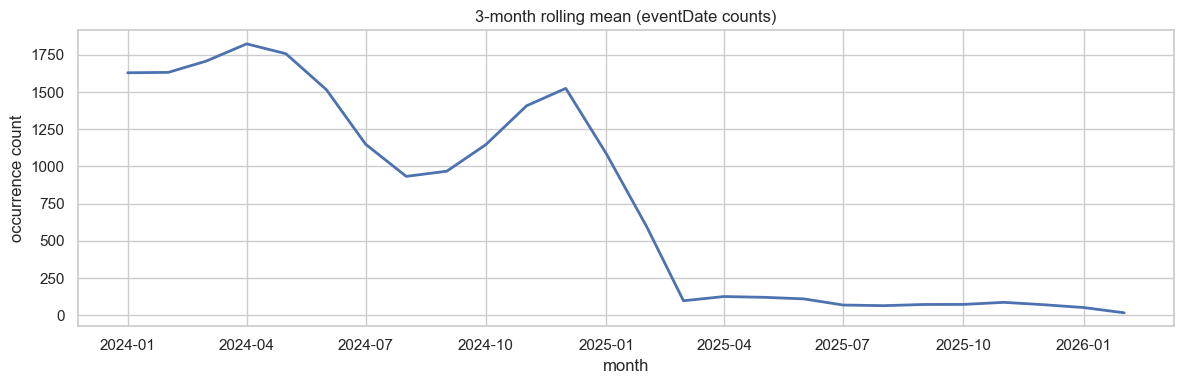

In [23]:
def _to_utc(ts: pd.Timestamp) -> pd.Timestamp:
    """Ensure a Timestamp is UTC tz-aware."""
    if getattr(ts, "tz", None) is None:
        return ts.tz_localize("UTC")
    return ts.tz_convert("UTC")


def month_windows(start: pd.Timestamp, end: pd.Timestamp) -> list[tuple[pd.Timestamp, pd.Timestamp, str]]:
    """Return month windows as (month_start_utc, month_end_inclusive_utc, label_YYYY_MM).

    Note: Some pandas versions don't support tz=... in Period.to_timestamp(),
    so we localize/convert to UTC explicitly.
    """
    # Convert to naive UTC before to_period() to avoid timezone-drop warnings
    start_p = _to_utc(start).tz_localize(None).to_period("M")
    end_p = _to_utc(end).tz_localize(None).to_period("M")

    months = pd.period_range(start_p, end_p, freq="M")
    out: list[tuple[pd.Timestamp, pd.Timestamp, str]] = []
    for m in months:
        ms = _to_utc(m.to_timestamp(how="start"))
        me_excl = _to_utc((m + 1).to_timestamp(how="start"))
        me = me_excl - pd.Timedelta(seconds=1)  # inclusive end
        out.append((ms, me, str(m)))
    return out


def gbif_count_occurrences(
    bbox: dict,
    taxon_key: int | None,
    species_key: int | None,
    date_range: str,
    date_field: str = "eventDate",
) -> int:
    """Fast count-only query against GBIF Occurrence Search API.

    date_field:
      - "eventDate" -> observation time
      - "lastInterpreted" / "modified" -> GBIF processing/record update time ("as-of" approximations)
    """
    kwargs = dict(
        decimalLatitude=f"{bbox['min_lat']},{bbox['max_lat']}",
        decimalLongitude=f"{bbox['min_lon']},{bbox['max_lon']}",
        hasCoordinate=True,
        limit=0,
        offset=0,
    )
    if taxon_key is not None:
        kwargs["taxonKey"] = taxon_key
    if species_key is not None:
        kwargs["speciesKey"] = species_key

    kwargs[date_field] = date_range

    resp = occurrences.search(**kwargs)
    return int(resp.get("count", 0))


def build_monthly_count_series(
    bbox: dict,
    taxon_key: int | None,
    species_key: int | None,
    start: pd.Timestamp,
    end: pd.Timestamp,
    date_field: str = "eventDate",
    cache_dir: Path = CACHE_DIR,
) -> pd.DataFrame:
    """Compute (or load cached) monthly counts."""
    safe_species = str(species_key) if species_key is not None else ("by_name" if SPECIES_NAME else "all")
    cache_path = cache_dir / (
        f"gbif_monthly_counts_{safe_city}_r{RADIUS_KM}km_taxon{taxon_key}_species{safe_species}_{date_field}_{start.date()}_{end.date()}.csv"
    )

    if cache_path.exists():
        out = pd.read_csv(cache_path)
        out["month_start"] = pd.to_datetime(out["month_start"], utc=True)
        out["month"] = out["month"].astype(str)
        return out

    rows = []
    for ms, me, label in tqdm(month_windows(start, end), desc=f"GBIF monthly counts ({date_field})"):
        dr = f"{ms.date()},{me.date()}"  # GBIF accepts YYYY-MM-DD,YYYY-MM-DD
        c = gbif_count_occurrences(bbox, taxon_key, species_key, dr, date_field=date_field)
        rows.append({"month": label, "month_start": ms, "count": c})

    out = pd.DataFrame(rows).sort_values("month_start")
    out.to_csv(cache_path, index=False)
    print("Saved:", cache_path)
    return out


# Build the series (eventDate = observation month)
monthly = build_monthly_count_series(
    bbox=BBOX,
    taxon_key=TAXON_KEY,
    species_key=SPECIES_KEY,
    start=START,
    end=END,
    date_field="eventDate",
)

display(monthly.tail(12))

plt.figure(figsize=(12, 4))
plt.plot(monthly["month_start"], monthly["count"], marker="o", linewidth=1)
plt.title(
    f"Monthly GBIF occurrence count — {SPECIES_NAME or 'speciesKey='+str(SPECIES_KEY)}\n{CITY} (~{RADIUS_KM} km), date_field=eventDate"
)
plt.xlabel("month")
plt.ylabel("occurrence count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(monthly["month_start"], monthly["count"].rolling(3, min_periods=1).mean(), linewidth=2)
plt.title("3-month rolling mean (eventDate counts)")
plt.xlabel("month")
plt.ylabel("occurrence count")
plt.tight_layout()
plt.show()

### 13) “As-of date” snapshots (2024 vs 2025 vs 2026)

What you described (“download the data **as of** 2024, then 2025, then 2026”) can mean two different things:

- **Ecology / observations over time**: use **`eventDate`** windows (what happened *when it was observed*).
- **What GBIF knew at a point in time** (reporting / ingestion / backfills): use **`lastInterpreted`** or **`modified`** windows. This is an *approximation* of a snapshot.

For strict reproducibility, GBIF supports **download jobs** (with a download key) that can be re-cited later. The simple `occurrences.search()` queries are great for exploration, but they’re not guaranteed to be identical over time.

GBIF monthly counts (lastInterpreted):   0%|          | 0/26 [00:00<?, ?it/s]

Saved: data/gbif_monthly_counts_madrid_spain_r30km_taxonNone_species5229490_lastInterpreted_2024-01-01_2026-02-06.csv


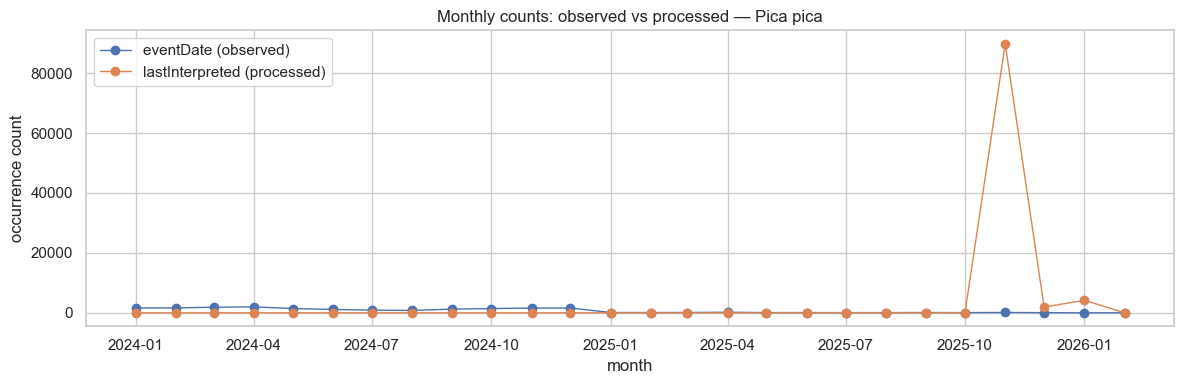

In [24]:
# Optional: compare against an "as-of" series using lastInterpreted (what GBIF processed in that month)
# This is NOT the same as observation time; it reflects GBIF ingestion/processing.

monthly_last = build_monthly_count_series(
    bbox=BBOX,
    taxon_key=TAXON_KEY,
    species_key=SPECIES_KEY,
    start=START,
    end=END,
    date_field="lastInterpreted",
)

plt.figure(figsize=(12, 4))
plt.plot(monthly["month_start"], monthly["count"], marker="o", linewidth=1, label="eventDate (observed)")
plt.plot(monthly_last["month_start"], monthly_last["count"], marker="o", linewidth=1, label="lastInterpreted (processed)")
plt.title(f"Monthly counts: observed vs processed — {SPECIES_NAME or 'speciesKey='+str(SPECIES_KEY)}")
plt.xlabel("month")
plt.ylabel("occurrence count")
plt.legend()
plt.tight_layout()
plt.show()

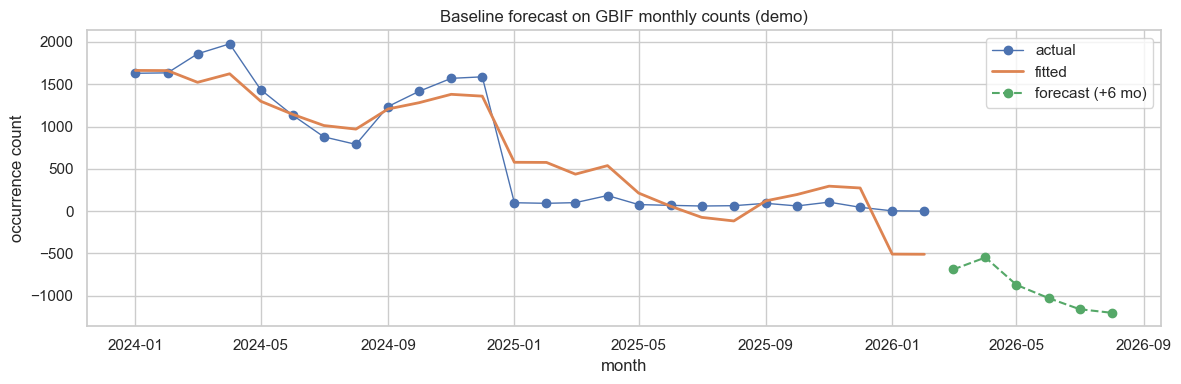

Forecast months:
2026-03-01 -> 0
2026-04-01 -> 0
2026-05-01 -> 0
2026-06-01 -> 0
2026-07-01 -> 0
2026-08-01 -> 0


In [25]:
# Simple forecast demo (NOT ecology, just a baseline on observation counts)
# We'll fit a linear model with seasonality features (month-of-year) and forecast a few months ahead.

from sklearn.linear_model import LinearRegression


def add_features(ts: pd.DataFrame) -> pd.DataFrame:
    out = ts.copy()
    out["t"] = np.arange(len(out))
    out["month_of_year"] = out["month_start"].dt.month.astype(int)
    # Seasonality as one-hot
    d = pd.get_dummies(out["month_of_year"], prefix="m", drop_first=True)
    out = pd.concat([out, d], axis=1)
    return out


feat = add_features(monthly)
feature_cols = ["t"] + [c for c in feat.columns if c.startswith("m_")]
X = feat[feature_cols].values
y = feat["count"].values

model = LinearRegression()
model.fit(X, y)
feat["pred"] = model.predict(X)

# Forecast next N months
N_FC = 6
last = monthly["month_start"].max().tz_localize(None).to_period("M")
future_months = [_to_utc((last + i).to_timestamp(how="start")) for i in range(1, N_FC + 1)]
future = pd.DataFrame({"month_start": future_months})
future["t"] = np.arange(len(feat), len(feat) + len(future))
future["month_of_year"] = future["month_start"].dt.month.astype(int)
future = pd.concat([future, pd.get_dummies(future["month_of_year"], prefix="m", drop_first=True)], axis=1)

# Align dummy columns
for c in [c for c in feat.columns if c.startswith("m_")]:
    if c not in future.columns:
        future[c] = 0
future = future[["month_start"] + feature_cols]

future_pred = model.predict(future[feature_cols].values)

plt.figure(figsize=(12, 4))
plt.plot(monthly["month_start"], monthly["count"], marker="o", linewidth=1, label="actual")
plt.plot(feat["month_start"], feat["pred"], linewidth=2, label="fitted")
plt.plot(future["month_start"], future_pred, marker="o", linestyle="--", label=f"forecast (+{N_FC} mo)")
plt.title("Baseline forecast on GBIF monthly counts (demo)")
plt.xlabel("month")
plt.ylabel("occurrence count")
plt.legend()
plt.tight_layout()
plt.show()

print("Forecast months:")
for dt, p in zip(future["month_start"], future_pred):
    print(dt.date(), "->", int(round(max(p, 0))))

### 12b) Why did the monthly count drop so much? (diagnostics)

A sharp drop like this is **usually not evidence that the species disappeared**. With GBIF occurrence counts, the most common explanations are:

- **Reporting effort changed** (fewer observers, platform usage, or data export cadence)
- **Data source/provider changed** (a major dataset stopped publishing into GBIF for that time period)
- **Ingestion / processing effects** (records exist but were interpreted/updated at different times)
- **Query artifacts** (filters too strict, taxon key mismatch, bounding box too small, etc.)

Below are quick sanity checks to distinguish these cases.

GBIF monthly counts (eventDate):   0%|          | 0/26 [00:00<?, ?it/s]

Saved: data/gbif_monthly_counts_madrid_spain_r30km_taxonNone_speciesby_name_eventDate_2024-01-01_2026-02-06.csv


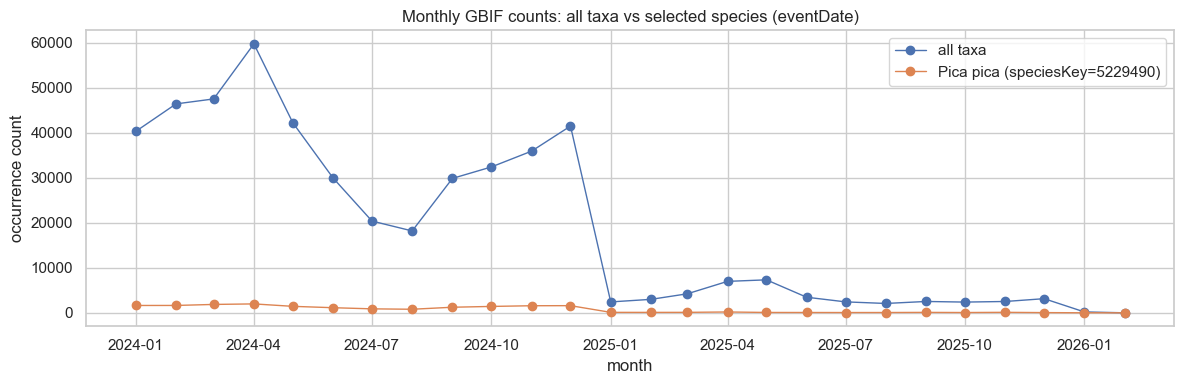

,month_start,count_all,count_species,species_share
14,2025-03-01 00:00:00+00:00,4223,100,0.023680
15,2025-04-01 00:00:00+00:00,6986,184,0.026338
16,2025-05-01 00:00:00+00:00,7326,77,0.010511
17,2025-06-01 00:00:00+00:00,3461,68,0.019648
18,2025-07-01 00:00:00+00:00,2429,60,0.024702
19,2025-08-01 00:00:00+00:00,2076,64,0.030829
20,2025-09-01 00:00:00+00:00,2519,92,0.036522
21,2025-10-01 00:00:00+00:00,2382,61,0.025609
22,2025-11-01 00:00:00+00:00,2515,106,0.042147
23,2025-12-01 00:00:00+00:00,3139,45,0.014336


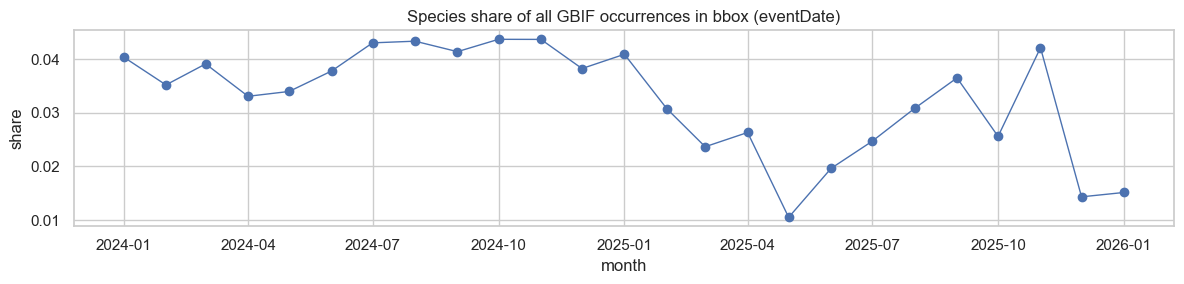

In [26]:
# 1) Is the drop species-specific, or does *all* GBIF activity in the bbox drop too?
# Build overall monthly counts (no species filter) and compare.

monthly_all = build_monthly_count_series(
    bbox=BBOX,
    taxon_key=TAXON_KEY,
    species_key=None,
    start=START,
    end=END,
    date_field="eventDate",
)

plt.figure(figsize=(12, 4))
plt.plot(monthly_all["month_start"], monthly_all["count"], marker="o", linewidth=1, label="all taxa")
plt.plot(monthly["month_start"], monthly["count"], marker="o", linewidth=1, label=f"{SPECIES_NAME} (speciesKey={SPECIES_KEY})")
plt.title("Monthly GBIF counts: all taxa vs selected species (eventDate)")
plt.xlabel("month")
plt.ylabel("occurrence count")
plt.legend()
plt.tight_layout()
plt.show()

# Fraction of all observations that are this species
merged = monthly_all[["month_start", "count"]].merge(
    monthly[["month_start", "count"]], on="month_start", suffixes=("_all", "_species")
)
merged["species_share"] = merged["count_species"] / merged["count_all"].replace(0, np.nan)

display(merged.tail(12))

plt.figure(figsize=(12, 3))
plt.plot(merged["month_start"], merged["species_share"], marker="o", linewidth=1)
plt.title("Species share of all GBIF occurrences in bbox (eventDate)")
plt.xlabel("month")
plt.ylabel("share")
plt.tight_layout()
plt.show()

In [27]:
# 2) Are counts being driven by a single dataset/provider, and did that source change?
# We'll sample a small number of records for months before/after the drop and inspect datasetKey / institutionCode.


def gbif_sample_occurrences(
    bbox: dict,
    taxon_key: int | None,
    species_key: int | None,
    date_range: str,
    date_field: str = "eventDate",
    limit: int = 300,
) -> pd.DataFrame:
    kwargs = dict(
        decimalLatitude=f"{bbox['min_lat']},{bbox['max_lat']}",
        decimalLongitude=f"{bbox['min_lon']},{bbox['max_lon']}",
        hasCoordinate=True,
        limit=limit,
        offset=0,
    )
    if taxon_key is not None:
        kwargs["taxonKey"] = taxon_key
    if species_key is not None:
        kwargs["speciesKey"] = species_key
    kwargs[date_field] = date_range

    resp = occurrences.search(**kwargs)
    return pd.DataFrame(resp.get("results", []))


# Pick months around the cliff (adjust if your plot shows a different breakpoint)
MONTHS_TO_CHECK = [
    ("2024-10-01", "2024-10-31"),
    ("2024-12-01", "2024-12-31"),
    ("2025-01-01", "2025-01-31"),
    ("2025-03-01", "2025-03-31"),
]

samples = []
for a, b in MONTHS_TO_CHECK:
    dr = f"{a},{b}"
    tmp = gbif_sample_occurrences(BBOX, TAXON_KEY, SPECIES_KEY, dr, date_field="eventDate", limit=300)
    tmp["window"] = f"{a[:7]}"
    samples.append(tmp)

samp = pd.concat(samples, ignore_index=True) if samples else pd.DataFrame()

keep = [c for c in ["window", "datasetKey", "publishingOrgKey", "institutionCode", "collectionCode", "basisOfRecord", "license", "rightsHolder", "references"] if c in samp.columns]

print("Sample rows:", len(samp))
display(samp[keep].head(10))

if "datasetKey" in samp.columns:
    display(samp.groupby(["window", "datasetKey"]).size().rename("rows").reset_index().sort_values(["window", "rows"], ascending=[True, False]).head(30))

if "institutionCode" in samp.columns:
    display(samp.groupby(["window", "institutionCode"]).size().rename("rows").reset_index().sort_values(["window", "rows"], ascending=[True, False]).head(30))

if "references" in samp.columns:
    from urllib.parse import urlparse

    domains = samp["references"].dropna().astype(str).map(lambda u: urlparse(u).netloc.lower())
    display(domains.value_counts().head(10).to_frame("rows"))

Sample rows: 799


,window,datasetKey,publishingOrgKey,institutionCode,collectionCode,basisOfRecord,license,rightsHolder,references
0,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,Gabriel Bienzobas Fernández,https://www.inaturalist.org/observations/24553...
1,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,yesmarko,https://www.inaturalist.org/observations/24558...
2,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,ARSENIO GONZALEZ NAVARRO,https://www.inaturalist.org/observations/24536...
3,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,jacobomaldo,https://www.inaturalist.org/observations/24599...
4,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,ARSENIO GONZALEZ NAVARRO,https://www.inaturalist.org/observations/24611...
5,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,ARSENIO GONZALEZ NAVARRO,https://www.inaturalist.org/observations/24536...
6,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,victorgc07,https://www.inaturalist.org/observations/24541...
7,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,ARSENIO GONZALEZ NAVARRO,https://www.inaturalist.org/observations/24519...
8,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,ARSENIO GONZALEZ NAVARRO,https://www.inaturalist.org/observations/24536...
9,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,iNaturalist,Observations,HUMAN_OBSERVATION,http://creativecommons.org/licenses/by-nc/4.0/...,ARSENIO GONZALEZ NAVARRO,https://www.inaturalist.org/observations/24536...


,window,datasetKey,rows
0,2024-10,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,237
1,2024-10,50c9509d-22c7-4a22-a47d-8c48425ef4a7,44
3,2024-10,8a863029-f435-446a-821e-275f4f641165,16
2,2024-10,6ff8b3b0-ef0f-4f79-a310-5a5615c6aa0b,3
4,2024-12,4fa7b334-ce0d-4e88-aaae-2e0c138d049e,240
5,2024-12,50c9509d-22c7-4a22-a47d-8c48425ef4a7,46
7,2024-12,8a863029-f435-446a-821e-275f4f641165,12
6,2024-12,6ff8b3b0-ef0f-4f79-a310-5a5615c6aa0b,1
8,2024-12,b1047888-ae52-4179-9dd5-5448ea342a24,1
9,2025-01,50c9509d-22c7-4a22-a47d-8c48425ef4a7,72


,window,institutionCode,rows
0,2024-10,CLO,237
1,2024-10,iNaturalist,44
2,2024-12,CLO,240
3,2024-12,iNaturalist,46
4,2025-01,iNaturalist,72
5,2025-03,iNaturalist,69


,rows
references,
www.inaturalist.org,231
data.biodiversitydata.nl,1


In [28]:
# 3) Taxon-key sanity check: speciesKey vs scientificName
# Sometimes taxonomic backbone changes or matching issues can affect counts.

if SPECIES_NAME:
    # Compare one month counts: speciesKey filter vs scientificName filter
    TEST_RANGE = "2024-04-01,2024-04-30"

    c_key = gbif_count_occurrences(BBOX, TAXON_KEY, SPECIES_KEY, TEST_RANGE, date_field="eventDate")
    c_name = occurrences.search(
        decimalLatitude=f"{BBOX['min_lat']},{BBOX['max_lat']}",
        decimalLongitude=f"{BBOX['min_lon']},{BBOX['max_lon']}",
        hasCoordinate=True,
        scientificName=SPECIES_NAME,
        eventDate=TEST_RANGE,
        limit=0,
        offset=0,
    ).get("count", 0)

    print("Test month:", TEST_RANGE)
    print("Count with speciesKey:", c_key)
    print("Count with scientificName:", int(c_name))
else:
    print("SPECIES_NAME is None; skip scientificName comparison.")

Test month: 2024-04-01,2024-04-30
Count with speciesKey: 1978
Count with scientificName: 1978


### 14) GBIF record counts by European country (limit=0)

This section answers: **“How many GBIF occurrence records exist for each European country?”**

Implementation notes:
- We use `occurrences.search(..., limit=0)` and read the response **`count`** (fast, no downloads).
- Counts can be very large and are **not directly comparable** between countries (area, reporting effort, publishing pipelines).
- You can optionally restrict to `hasCoordinate=True` and/or an `eventDate` window (recommended if you want a comparable time slice).

In [29]:
# Configure the slice you want to count
# If you want an all-time snapshot, keep EVENT_DATE_RANGE=None.
# For a comparable time slice, set a range like: "2024-01-01,2024-12-31".

HAS_COORDINATE = True
EVENT_DATE_RANGE = None  # e.g. "2024-01-01,2024-12-31"

# European countries (ISO 3166-1 alpha-2). Kosovo (XK) is intentionally omitted.
EUROPE_COUNTRIES = [
    ("AL", "Albania"),
    ("AD", "Andorra"),
    ("AM", "Armenia"),
    ("AT", "Austria"),
    ("AZ", "Azerbaijan"),
    ("BY", "Belarus"),
    ("BE", "Belgium"),
    ("BA", "Bosnia and Herzegovina"),
    ("BG", "Bulgaria"),
    ("HR", "Croatia"),
    ("CY", "Cyprus"),
    ("CZ", "Czechia"),
    ("DK", "Denmark"),
    ("EE", "Estonia"),
    ("FI", "Finland"),
    ("FR", "France"),
    ("GE", "Georgia"),
    ("DE", "Germany"),
    ("GR", "Greece"),
    ("HU", "Hungary"),
    ("IS", "Iceland"),
    ("IE", "Ireland"),
    ("IT", "Italy"),
    ("LV", "Latvia"),
    ("LI", "Liechtenstein"),
    ("LT", "Lithuania"),
    ("LU", "Luxembourg"),
    ("MT", "Malta"),
    ("MD", "Moldova"),
    ("MC", "Monaco"),
    ("ME", "Montenegro"),
    ("NL", "Netherlands"),
    ("MK", "North Macedonia"),
    ("NO", "Norway"),
    ("PL", "Poland"),
    ("PT", "Portugal"),
    ("RO", "Romania"),
    ("RU", "Russia"),
    ("SM", "San Marino"),
    ("RS", "Serbia"),
    ("SK", "Slovakia"),
    ("SI", "Slovenia"),
    ("ES", "Spain"),
    ("SE", "Sweden"),
    ("CH", "Switzerland"),
    ("TR", "Turkey"),
    ("UA", "Ukraine"),
    ("GB", "United Kingdom"),
    ("VA", "Vatican City"),
]

print("Countries:", len(EUROPE_COUNTRIES))
print("HAS_COORDINATE:", HAS_COORDINATE)
print("EVENT_DATE_RANGE:", EVENT_DATE_RANGE)

Countries: 49
HAS_COORDINATE: True
EVENT_DATE_RANGE: None


In [30]:
# Count per country (cached to CSV)

from datetime import date


def gbif_count_country(country_code: str, has_coordinate: bool = True, event_date_range: str | None = None) -> int:
    kwargs = dict(country=country_code, limit=0, offset=0)
    if has_coordinate:
        kwargs["hasCoordinate"] = True
    if event_date_range is not None:
        kwargs["eventDate"] = event_date_range
    resp = occurrences.search(**kwargs)
    return int(resp.get("count", 0))


slice_tag = "all_time" if EVENT_DATE_RANGE is None else EVENT_DATE_RANGE.replace(",", "_")
cache_path = CACHE_DIR / f"gbif_europe_country_counts_hasCoord{int(HAS_COORDINATE)}_{slice_tag}.csv"

if cache_path.exists():
    df_eu = pd.read_csv(cache_path)
    print("Loaded:", cache_path)
else:
    rows = []
    for code, name in tqdm(EUROPE_COUNTRIES, desc="GBIF counts by country (Europe)"):
        try:
            c = gbif_count_country(code, has_coordinate=HAS_COORDINATE, event_date_range=EVENT_DATE_RANGE)
            rows.append({"country": code, "name": name, "count": c})
        except Exception as e:
            rows.append({"country": code, "name": name, "count": np.nan, "error": str(e)})

    df_eu = pd.DataFrame(rows)
    df_eu.to_csv(cache_path, index=False)
    print("Saved:", cache_path)

# Show results
if "count" in df_eu.columns:
    display(df_eu.sort_values("count", ascending=False).head(20))

missing = df_eu["count"].isna().sum() if "count" in df_eu.columns else None
print("Missing counts:", missing)

Loaded: data/gbif_europe_country_counts_hasCoord1_all_time.csv


,country,name,count
15,FR,France,209814439
47,GB,United Kingdom,201918518
43,SE,Sweden,166245174
31,NL,Netherlands,137429312
42,ES,Spain,91044109
33,NO,Norway,81235483
17,DE,Germany,77984968
12,DK,Denmark,66135538
14,FI,Finland,51103968
6,BE,Belgium,44798325


Missing counts: 0


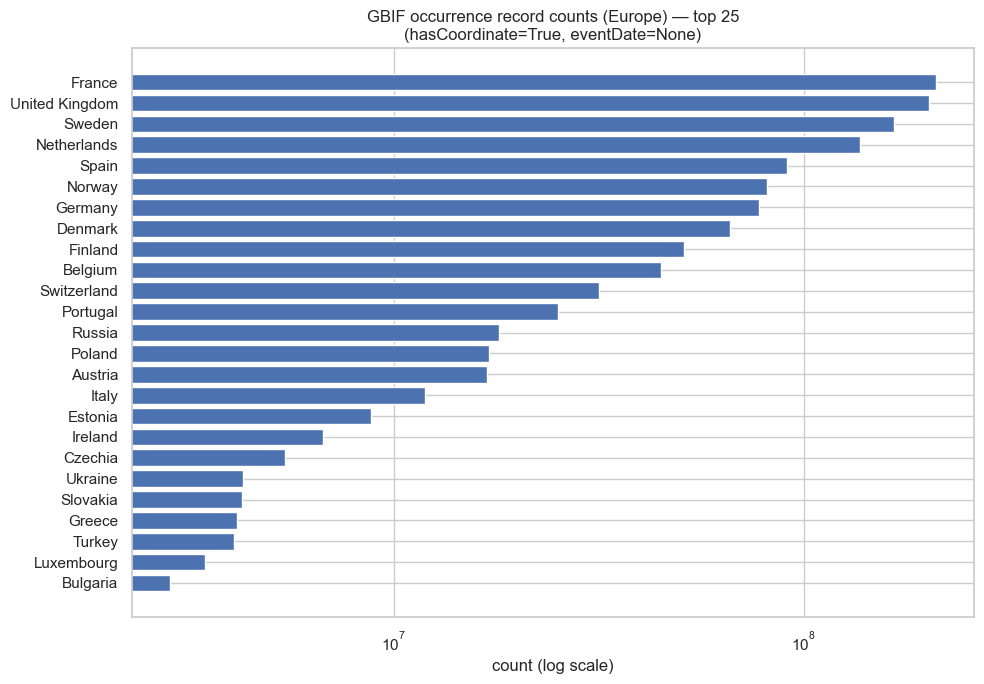

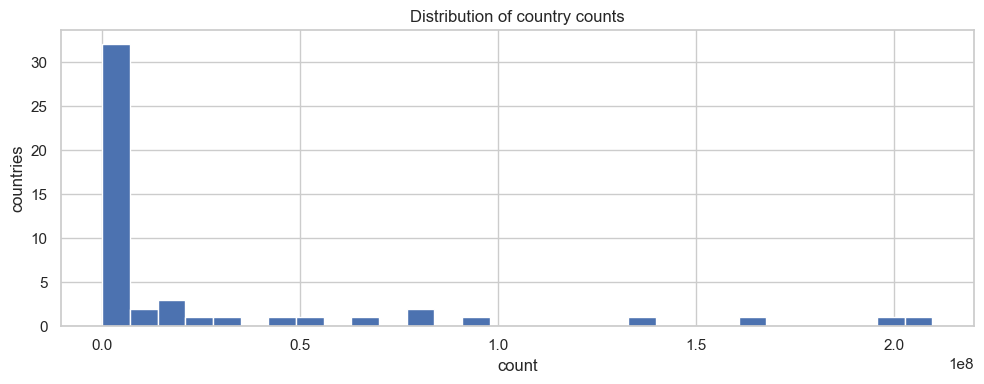

In [31]:
# Plot: sorted bar chart (use log scale if needed)

df_plot = df_eu.dropna(subset=["count"]).copy()
df_plot = df_plot.sort_values("count", ascending=True)

TOP_N = 25
log_scale = True  # set False if you prefer linear

subset = df_plot.tail(TOP_N)

plt.figure(figsize=(10, 7))
plt.barh(subset["name"], subset["count"])
plt.title(f"GBIF occurrence record counts (Europe) — top {TOP_N}\n(hasCoordinate={HAS_COORDINATE}, eventDate={EVENT_DATE_RANGE})")
plt.xlabel("count" + (" (log scale)" if log_scale else ""))
if log_scale:
    plt.xscale("log")
plt.tight_layout()
plt.show()

# Full distribution (optional quick view)
plt.figure(figsize=(10, 4))
plt.hist(df_plot["count"], bins=30)
plt.title("Distribution of country counts")
plt.xlabel("count")
plt.ylabel("countries")
plt.tight_layout()
plt.show()

### 15) Protected / threatened species: how to join external lists with GBIF

First, a distinction:
- **Threatened** (e.g. IUCN Red List: VU/EN/CR) = conservation status.
- **Protected** (legal protection) depends on jurisdiction (EU directives, CITES, national red lists/law).

Good news: joining is doable if you normalize everything to a stable identifier, ideally **GBIF `speciesKey`**.

Below we show two approaches:
1) Use the `iucnRedListCategory` field already present in many GBIF occurrences (quick “threatened” flag).
2) Join an external protected-species list (CSV) by mapping names → GBIF backbone → `speciesKey`.

In [32]:
# Approach 1: threatened species using iucnRedListCategory (if present in the GBIF records)

IUCN_THREATENED = {"VU", "EN", "CR", "EW", "EX"}

if "iucnRedListCategory" in df_raw.columns:
    tmp = df_raw[[c for c in ["species", "speciesKey", "iucnRedListCategory", "datasetKey", "license"] if c in df_raw.columns]].copy()

    # Distribution of categories
    display(tmp["iucnRedListCategory"].fillna("MISSING").value_counts().to_frame("records"))

    # Unique threatened species in this slice
    threatened = tmp[tmp["iucnRedListCategory"].isin(IUCN_THREATENED)].copy()
    print("Threatened categories:", sorted(IUCN_THREATENED))
    print("Threatened records:", len(threatened))
    if "species" in threatened.columns:
        print("Unique threatened species:", threatened["species"].nunique(dropna=True))
        display(threatened[[c for c in ["species", "speciesKey", "iucnRedListCategory"] if c in threatened.columns]].drop_duplicates().head(30))
else:
    print("No iucnRedListCategory in df_raw. You'll need an external source (IUCN/CITES/EU lists) to label species.")

,records
iucnRedListCategory,
LC,1434
MISSING,462
NT,53
EN,25
VU,25
DD,1


Threatened categories: ['CR', 'EN', 'EW', 'EX', 'VU']
Threatened records: 50
Unique threatened species: 6


,species,speciesKey,iucnRedListCategory
26,Oryctolagus cuniculus,2436940.0,EN
60,Macrochloa tenacissima,4127897.0,VU
191,Lanius meridionalis,7341500.0,VU
354,Aythya ferina,2498255.0,VU
660,Pararge aegeria,8049830.0,EN
735,Aquila adalberti,2480510.0,VU


### 16) GBIF data quality flags (`issues`) — counts and % of records

GBIF provides an `issues` field that flags potential data-quality problems (geospatial, taxonomic, date parsing, etc.).

Below we summarize:
- the % of records that have **any** issue
- the distribution of individual issue codes with **counts** and **% of total records**

In [34]:
import pandas as pd


def issues_summary(df: pd.DataFrame, issues_col: str = "issues") -> pd.DataFrame:
    """Return per-issue counts and % of total records.

    Also prints the share of records that have any issues.
    """
    if issues_col not in df.columns:
        raise ValueError(f"Column {issues_col!r} not found. Available columns: {list(df.columns)[:50]}")

    n_total = len(df)
    s = df[issues_col]

    def to_list(x):
        if x is None or (isinstance(x, float) and pd.isna(x)):
            return []
        if isinstance(x, list):
            return x
        if isinstance(x, str):
            # sometimes stored as comma/semicolon-separated text
            parts = [p.strip() for p in x.replace(";", ",").split(",")]
            return [p for p in parts if p]
        return []

    issues_lists = s.map(to_list)

    has_any = issues_lists.map(len).gt(0)
    n_with_any = int(has_any.sum())
    print(f"Total records: {n_total}")
    print(f"Records with any issues: {n_with_any} ({(n_with_any / n_total * 100 if n_total else 0):.2f}%)")

    exploded = issues_lists.explode().dropna()

    counts = exploded.value_counts()

    # Be robust to pandas/index naming differences:
    # after reset_index the first column name can vary, so rename by position.
    out = counts.reset_index()
    out.columns = ["issue", "records"]

    if n_total:
        out["pct"] = (out["records"] / n_total * 100).round(2)
    else:
        out["pct"] = 0.0

    out = out.sort_values(["records", "issue"], ascending=[False, True])
    return out


# Prefer df_raw (raw GBIF response) because it reliably contains `issues`
base = df_raw if "issues" in df_raw.columns else df

issues_df = issues_summary(base)
display(issues_df.head(50))

Total records: 2000
Records with any issues: 1620 (81.00%)


,issue,records,pct
0,CONTINENT_DERIVED_FROM_COORDINATES,1619,80.95
1,TAXON_ID_NOT_FOUND,1614,80.70
2,COORDINATE_ROUNDED,1517,75.85
3,TAXON_MATCH_HIGHERRANK,6,0.30
4,TAXON_MATCH_NONE,4,0.20
5,SCIENTIFIC_NAME_ID_NOT_FOUND,1,0.05
6,TAXON_CONCEPT_ID_NOT_FOUND,1,0.05
7,TAXON_MATCH_FUZZY,1,0.05


### 17) Downloading *all* GBIF occurrences for Spain (ES) at scale (download jobs)

If you want to pull **all occurrences for a whole country** (Spain can be on the order of \(10^8\) records), **do not** try to paginate `occurrences.search()`.

Instead, use **GBIF download jobs**:
- GBIF runs the query asynchronously on their side
- you get a **download key** and a downloadable archive
- it is the only practical way to fetch tens of millions of records

Because the dataset is huge, you should **partition** the download into smaller jobs, e.g.:
- by **year** (recommended)
- optionally also by **region** (e.g., an admin boundary identifier) or by a **spatial grid**

This section shows:
- how to submit downloads with `pygbif`
- how to poll status
- a simple way to partition by **year** for `country=ES`

> Note: GBIF downloads require a GBIF account (username/password/email). Store credentials in environment variables, not in the notebook.